In [ ]:
import ase.io
from icet.tools import enumerate_structures
import itertools
import numpy as np
from src.feof.cem_functions_new import get_bad_structures,cem_generator,get_cem_new,get_cve,plot_eci,displt_expansion,get_cve_displt,get_convex_hull,get_50_50_structures
import pandas as pd
import os
from icet import ClusterExpansion
from mchammer.ensembles import CanonicalAnnealing
from mchammer import DataContainer
from mchammer.calculators import ClusterExpansionCalculator
from icet.tools.structure_generation import occupy_structure_randomly
from src.feof.clean_poscar import generate_vasp_poscar
from icet.tools import map_structure_to_reference



<h3> Size 2 structures cluster expansion. Trining data is DFT-relaxed structures upto size 2.</h3>

======================== Structure Container =========================
Total number of structures: 138
----------------------------------------------------------------------
index | user_tag | n_atoms | chemical formula | dft_energies_per_fu
----------------------------------------------------------------------
0     | None     | 6       | Fe2O4            |  -11.5505          
1     | None     | 6       | FFe2O3           |  -11.0162          
2     | None     | 6       | F2Fe2O2          |  -10.2060          
3     | None     | 6       | F2Fe2O2          |  -10.3673          
4     | None     | 6       | F3Fe2O           |   -9.4824          
5     | None     | 6       | F4Fe2            |   -8.5345          
6     | None     | 12      | FFe4O7           |  -11.2840          
7     | None     | 12      | F2Fe4O6          |  -10.9527          
8     | None     | 12      | F2Fe4O6          |  -10.9921          
9     | None     | 12      | F3Fe4O5          |  -10.6324          
10    |

/tmp/ipykernel_859071/3708257260.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_859071/3708257260.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


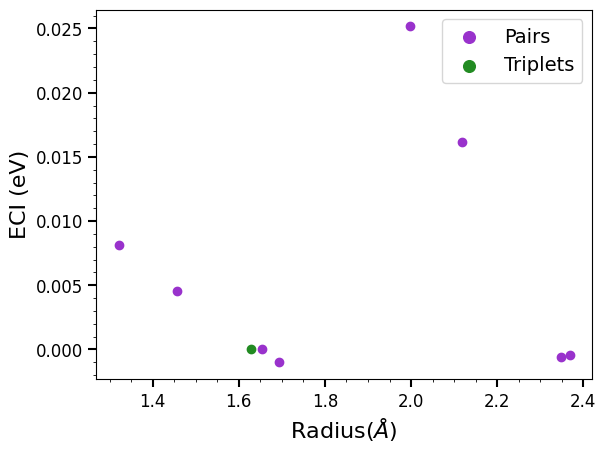

In [ ]:
struct = ase.io.read('./FeF2.vasp')
cluster_list = [[['Fe']]*2,[['O','F']]*4]
cutoffs = [5,3] #Set as per requirement
cve,ce = cem_generator(struct,cluster_list,cutoffs,'lasso',max_size=2,is_50_50=False)
fig,ax = plot_eci(ce)
ax.set_xlabel("Radius($\AA$)",size=16)
ax.set_ylabel("ECI (eV)",size=16)
ax.tick_params(axis='x',labelsize=12,size=6,width=1.5)
ax.tick_params(axis='y',labelsize=12,size=6,width=1.5)
ax.minorticks_on()
ax.legend(prop={'size':14},markerscale=1.4)
fig.show()
#fig.savefig('feof_nomag_eci_lasso_final.pdf',dpi=500,bbox_inches='tight')
fig.show()
print(cve)

In [28]:
print(ce)
ce.write('ce_nonmag_size_2_lasso_cutoffs_5_3')

================================================ Cluster Expansion ================================================
 space group                            : P4_2/mnm (136)
 chemical species                       : ['F', 'O'] (sublattice A)
 cutoffs                                : 5.0000 3.0000
 total number of parameters             : 11
 number of parameters by order          : 0= 1  1= 1  2= 8  3= 1
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
 total number of nonzero parameters     : 9
 number of nonzero parameters by order  : 0= 1  1= 1  2= 7  3= 0 
-------------------------------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublattices | parameter |    ECI   
-----------------------------------------------------------------------------------------------------------

<h3>Get good size 3 50-50 structures from size 2 CEM to retrain. This use the trained size 2 model to predict the first 100 low-energy FeOF configurations in size 3 supercells, which will be subsequently relaxed using DFT and then fed into the revised CEM.</h3>

In [ ]:
ce_site_energies = ClusterExpansion.read('ce_nonmag_size_2_lasso_cutoffs_5_3')
struct = ase.io.read('./FeF2.vasp')
cluster_list = [[['Fe']]*2,[['O','F']]*4]
energies = []

for idx,structure in enumerate(enumerate_structures(struct,sizes=range(3,4),chemical_symbols=list(itertools.chain(*cluster_list)))):
    if structure.get_chemical_symbols().count('O') == structure.get_chemical_symbols().count('F'):
        energies.append({'structure':structure, 'energy': ce_site_energies.predict(structure)})

    # Sort the energies and get the 100 lowest energy structures
lowest_energy_structures = sorted(energies, key=lambda x: x['energy'])[:100]

for idx, structure in enumerate(lowest_energy_structures):
    ase.io.write('size_3_unrelaxed/POSCAR_'+str(138+idx),structure['structure'],direct=True)


<h3> Train size 3 nonmagnetic cluster model. This cell was executed with cutoffs of [5,3] and [7,4] for pairs and triplets respectively. </h3>

======================== Structure Container =========================
Total number of structures: 238
----------------------------------------------------------------------
index | user_tag | n_atoms | chemical formula | dft_energies_per_fu
----------------------------------------------------------------------
0     | None     | 6       | Fe2O4            |  -11.5505          
1     | None     | 6       | FFe2O3           |  -11.0162          
2     | None     | 6       | F2Fe2O2          |  -10.2060          
3     | None     | 6       | F2Fe2O2          |  -10.3673          
4     | None     | 6       | F3Fe2O           |   -9.4824          
5     | None     | 6       | F4Fe2            |   -8.5345          
6     | None     | 12      | FFe4O7           |  -11.2840          
7     | None     | 12      | F2Fe4O6          |  -10.9527          
8     | None     | 12      | F2Fe4O6          |  -10.9921          
9     | None     | 12      | F3Fe4O5          |  -10.6324          
10    |

/tmp/ipykernel_702479/3055841220.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


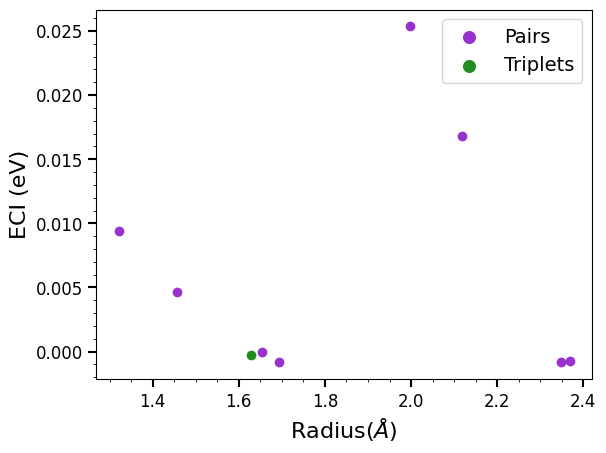

In [ ]:
struct = ase.io.read('./FeF2.vasp')
cluster_list = [[['Fe']]*2,[['O','F']]*4]
cutoffs = [5,3] #Set as per requirement
cve,ce = cem_generator(struct,cluster_list,cutoffs,'lasso',max_size=3,is_50_50=False)
fig,ax = plot_eci(ce)
ax.set_xlabel("Radius($\AA$)",size=16)
ax.set_ylabel("ECI (eV)",size=16)
ax.tick_params(axis='x',labelsize=12,size=6,width=1.5)
ax.tick_params(axis='y',labelsize=12,size=6,width=1.5)
ax.minorticks_on()
ax.legend(prop={'size':14},markerscale=1.4)
fig.show()
#fig.savefig('feof_nomag_eci_lasso_final.pdf',dpi=500,bbox_inches='tight')
print(cve)
ce.write('ce_nonmag_size_3_lasso_cutoffs_5_3')

<h3> Get ground state ordered structure from pbesol relaxations </h3>

In [2]:
# Define the columns to read from the CSV
energy_cols = ['STRUCTURE', 'ENERGY']
df_energy = pd.read_csv('./cem_training_energies_nm.txt', sep='\s+', usecols=energy_cols)

# Initialize an empty dictionary to store energies
energies = {}

# Iterate through the files in the directory
for idx in range(237):
    structure = ase.io.read("./unrelaxed_structures_all/POSCAR_{}".format(idx))
    
    # Check if the number of 'F' atoms equals the number of 'O' atoms
    if structure.get_chemical_symbols().count('F') == structure.get_chemical_symbols().count('O'):
        n_sites = len(structure) - structure.get_chemical_symbols().count('Fe')
        # Find the corresponding energy in the DataFrame
        energy_row = df_energy[df_energy['STRUCTURE'] == idx]
        #print(energy_row)
        # Ensure the energy exists before accessing it
        if not energy_row.empty:
            energy = energy_row['ENERGY'].values[0]
            energies[idx] = energy/n_sites

min_energy = sorted(energies.items(), key=lambda item: item[1])[:1]
min_energies = sorted(energies.items(), key=lambda item: item[1])[:10]
min_energies_normalized = np.array(sorted(energies.items(), key=lambda item: item[1])[:10]) - np.array(min_energy)

print(min_energies_normalized[:,1])


[0.         0.00152163 0.00242392 0.00647975 0.01602225 0.01956392
 0.02000225 0.02104725 0.02199058 0.02252975]
